# CrunchBase exploratory analysis

This notebook explores CrunchBase data to analyse the distribution of AI companies by sector. It will also be helpful for our collaborative MSc supervision with the Bank of England.

**Tasks**

1. Load data
2. Identify a suitable sectoral category
3. Flag AI companies
4. Study AI distribution by sector:
  * Question: Is there an AI gap? And is it growing or becoming smaller
5. Compare with sic codes?
6. Close


## Preamble

In [41]:
#Basic imports
import pandas as pd
import numpy as np
from data_getters.core import get_engine
from data_getters.inspector import get_schemas
from random import sample


import matplotlib.pyplot as plt

today_str = str(datetime.date.today())

In [3]:
#We create this type to deal with some Nones later
NoneType = type(None)

## Load data

In [4]:
#Connection to the database

con = get_engine("mysqldb_team.config")

#Read organisations
comps_chunks = pd.read_sql_table('crunchbase_organizations', con, chunksize=1000)

#Read categories
cats_chunks = pd.read_sql_table('crunchbase_organizations_categories', con, chunksize=1000)

#Concatenate the chunks into dfs
comps, cats = [pd.concat(x).reset_index(drop=True) for x in [comps_chunks,cats_chunks]]
#descr_short, descr_long = [comps[v].apply(lambda x: x.lower() if type(x)==str else np.nan) for v in ['short_description','long_description']]

/Users/jmateosgarcia/miniconda3/envs/tmppy36/lib/python3.6/site-packages/pymysql/cursors.py:166: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


In [5]:
print(len(comps))

print(len(cats))

print(len(set(cats['organization_id'])))

769091
1783860
709668


There are around 600,000K organisations without categories



In [6]:
comps.head()

,id,company_name,roles,permalink,domain,homepage_url,country,state_code,region,city,...,twitter_url,aliases,created_at,updated_at,primary_role,type,long_description,parent_id,is_health,mesh_terms
0,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,Formel D GmbH,company,/organization/formel-d-gmbh,formeld.com,http://www.formeld.com,Germany,None,DEU - Other,Troisdorf,...,https://www.twitter.com/formeld_es,None,2016-06-01 06:58:37,2018-10-26 22:19:19,company,organization,Formel D GmbH is a automotive manufacturer and...,None,0,None
1,000014da-0c46-b9cb-0941-3a93c027b119,Resilio,company,/organization/resiliohq,resiliohq.com,http://www.resiliohq.com,Denmark,None,None,Aarhus,...,https://twitter.com/andersresilio,None,2017-05-03 20:09:32,2018-10-26 23:15:32,company,organization,By combining state of the art signal processin...,None,1,"Games, Recreational|Signal Processing, Compute..."
2,00001b2d-a4f7-55d5-d69a-17acbac9c17b,STD Risk Calculator,company,/organization/std-risk-calculator,stdriskcalculator.com,http://www.stdriskcalculator.com,None,None,None,None,...,http://twitter.com/STDRisk,None,2012-03-18 06:23:27,2018-10-26 23:30:24,company,organization,STD Risk Calculator is a company dedicated to ...,None,1,Gonorrhea|Syphilis|Sexual Health|Sexually Tran...
3,00001dba-e22c-2285-55ee-352a8b087a04,Buy Man Things,company,/organization/buy-man-things,buymanthings.com,http://buymanthings.com,None,None,None,None,...,http://twitter.com/buymanthings,None,2013-08-10 00:59:51,2018-10-26 21:45:19,company,organization,Buy Man Things is an online men's magazine fea...,None,0,None
4,0000221d-6dfd-a049-dcfc-b4a5ca3b0fe7,Stabil Capital Management,company,/organization/stabil-capital-management,None,None,None,None,None,None,...,None,None,2016-10-03 16:35:46,2018-02-12 23:47:40,company,organization,None,None,0,None


In [7]:
cats.head()

,organization_id,category_name
0,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,automotive
1,00000aa4-ba42-9b68-a9c3-040c9f3bf9b9,manufacturing
2,000014da-0c46-b9cb-0941-3a93c027b119,education
3,000014da-0c46-b9cb-0941-3a93c027b119,health care
4,00001b2d-a4f7-55d5-d69a-17acbac9c17b,biotechnology


## Slight data processing

In [8]:
#Merge organisations and categories

#We reset the index because you can't merge series
cats_grouped = cats.groupby('organization_id')['category_name'].apply(lambda x: list(x)).reset_index(drop=False)

#This gives us a dataframe with a new field with the list of categories for the organisation
comps_cats = pd.merge(comps,cats_grouped,left_on='id',right_on='organization_id')

In [9]:
comps_cats.shape

(709244, 38)

This is as expected given the length of dfs above (there seems to be a small number of organisations in the `cat` df not included in the `comps` df but we can worry about that a bit later.

In [10]:
#Subset to focus on company entities.
#There are some missing values in roles, which we would also drop (Note the False in the control flow)

comps_cats = comps_cats.loc[['company' in x if type(x)!=NoneType else False for x in comps_cats['roles']]]

comps_cats.shape

(691385, 38)

### Identify 'AI' companies

In [11]:
#Find AI companies based on text description or the AI category

#These are the terms we use for now. TODO: expand these using semantic similarities
ai_terms = ['data science','machine learning', 'deep learning','artificial intelligence','neural network', ' ai ','natural language processing','text mining']

#Lowercase the text
comps_cats['long_description'] = comps_cats['long_description'].apply(lambda x: x.lower() if type(x)!=NoneType else np.nan)

#Count the number of times that a company mentions AI 
comps_cats['ai_text_n'] = [sum([term in x for term in ai_terms]) if pd.isnull(x)==False else np.nan for x in comps_cats['long_description']]

In [12]:
comps_cats['ai_text_n'].value_counts()

0.0    494737
1.0      7703
2.0      1912
3.0       396
4.0        70
5.0        17
6.0         1
Name: ai_text_n, dtype: int64

Most companies that mention AI do this once. Others mention it more often

In [13]:
#Check a few companies with more than 3 AI mentions to see what they do
for x in sample(list(comps_cats.loc[comps_cats['ai_text_n']>3]['long_description']),5):
    print(x)
    print('\n')

lightmatter is an artificial intelligence (ai) hardware company that uses integrated optical technology to create faster and more efficient processors. they accelerate critical operations in deep neural networks using an array of programmable photonic elements fabricated alongside transistors in conventional cmos processes (the same processes used to make cell phone chips). advantages of our optical processing technology include speed of light evaluations as well as low power consumption. by accelerating this core ai operation, they can speed up many of the software algorithms underlying image recognition, natural language processing, and more, thereby facilitating the next generation of ai-powered computing. founded in 2017, the company is headquartered in boston, massachusetts, united states.


about us: acer innovation is a global analytics firm with 90+ employees driving roi across diverse industries by leveraging data science. we have an agile team of phd data scientists and seaso

In [14]:
#Now we check AI in categories. Note there might be other relevant categories in the data but we will not do this for now
comps_cats['ai_cats'] = ['artificial intelligence' in c for c in comps_cats['category_name']]

comps_cats['ai_cats'].sum()

10324

In [15]:
#What is the overlap between companies with AI categories and AI relateed text in the description?
comp_cats_frequences = pd.crosstab(comps_cats['ai_text_n'],comps_cats['ai_cats'])

#What is the distribution of companies that mention AI various times over the share of companies with AI in their category?
comp_cats_frequences['text_share'] = 100*comp_cats_frequences[True]/comp_cats_frequences.sum(axis=1)

comp_cats_frequences

ai_cats,False,True,text_share
ai_text_n,,,
0.0,491030,3707,0.749287
1.0,4634,3069,39.841620
2.0,804,1108,57.949791
3.0,130,266,67.171717
4.0,8,62,88.571429
5.0,3,14,82.352941
6.0,0,1,100.000000


Around a third of companies with AI in their categories don't mention AI related terms in their descriptions.
There are quite a few companies that mention AI repeatedly but don't have an AI category.

In [16]:
# Quick check of company descriptions for companies that have AI cats but no AI Terms

#Check a few companies with more than 3 AI mentions to see what they do
for x in sample(list(comps_cats.loc[(comps_cats['ai_text_n']==0)&(comps_cats['ai_cats']==True)]['long_description']),5):
    print(x)
    print('\n')


webzsuite.com is a unique, one-stop, easy to use, business-oriented cloud-based applications suite for commercial website owners. webzsuite is providing revolutionary analytics, audits, metrics, competition research tools, marketing management, domain and hosting vaults and much more. 


organizationview is a pioneering people analytics practice. it's main product, workometry, lets clients replace employee surveys with open questions. workometry uses proprietary text analytics to analyse the thousands of multi-language responses providing new and deep insight that promotes action.


hioperator is a virtual assistant that answers phone calls, chats with customers, provides in-app help, takes orders, and provides support. the companys solution portfolio includes brand messaging, e-commerce ordering, product support, call screening, and customer analytics.  hioperators system can be integrated with a businesses current systems and is staffed by american opertors. hioperator was launche

The companies that have ai categories but no ai related terms in their description look quite noisy. Let's exclude them from the analysis for now

In [17]:
#Flag as AI companies with at least one AI term in their description. Later we could change this threshold
comps_cats['ai_flag'] = comps_cats['ai_text_n']>0

### A couple of descriptive analyses

#### Evolution

In [18]:
#We need to create a year variable (founded on is currently a date)
 
comps_cats['founded_year'] = [x.year if type(x)!=NoneType else np.nan for x in comps_cats['founded_on']]

(2000, 2018)

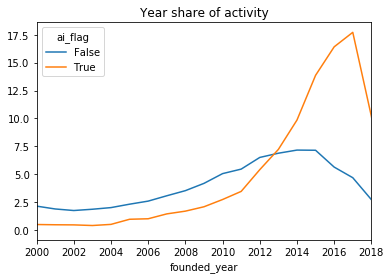

In [19]:
fig,ax = plt.subplots()

(100*pd.crosstab(comps_cats['founded_year'],comps_cats['ai_flag'],normalize=1)).plot(ax=ax,title='Year share of activity')

ax.set_xlim(2000,2018)


Very interesting: explosion of AI startup activity while startup activity in general slows-up. What else could be explaining this? China's entry?

#### Geography

In [20]:
#Calculate country distribution
country_distr = pd.crosstab(comps_cats['country'],comps_cats['ai_flag']).sort_values(True,ascending=False)

country_distr[:20]

ai_flag,False,True
country,,
United States,238113,3936
United Kingdom,42770,814
India,24739,452
Canada,19939,346
China,10149,307
Germany,13497,277
Israel,5038,269
France,12281,215
Brazil,9270,186


Some of the coverage issues are apparent - relatively limited activity in Japan. And where is China?

In [21]:
#Calculate index of comparative advantage
country_distr['ai_rca']= (country_distr[True]/country_distr[True].sum())/(country_distr.sum(axis=1)/country_distr.sum(axis=1).sum())

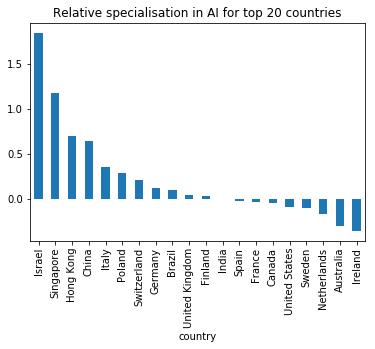

In [22]:
#Plot RCAs for top 20 countries by level of activity
(country_distr[:20]['ai_rca'].sort_values(ascending=False)-1).plot.bar(title='Relative specialisation in AI for top 20 countries')

Some results are expected (Israel, Singapore). Others (Canada), not so much.

In [23]:
#That gnarly pivot gives us the number of ai companies per year and country.
ai_country_counts = pd.pivot_table(comps_cats.groupby(['founded_year','country'])['ai_flag'].sum().reset_index(drop=False),index='country',columns='founded_year',values='ai_flag').fillna(0)

#We want to focus our visualisation on the top 10 countries by overall activity
bigger_countries = ai_country_counts.sum(axis=1).sort_values(ascending=False).index[:15]

#Consider share of activity in a given year

ai_country_shares = ai_country_counts.apply(lambda x: x/x.sum(),axis=1).fillna(0)

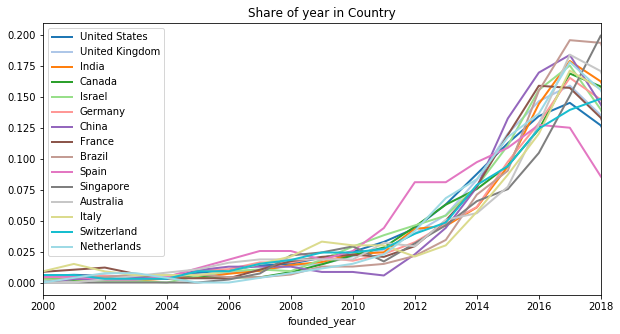

In [24]:
fig,ax = plt.subplots()

ai_country_shares.loc[bigger_countries].T.rolling(window=3).mean().plot(ax=ax,title='Share of year in Country',figsize=(10,5),cmap='tab20',linewidth=2)

ax.set_xlim(2000,2018)
ax.legend()

Everyone seems to be following a similar patterns perhaps with the exception of Singapore and Switzerland, which seem to be growing faster

#### Consider country sizes (TODO)

### Cluster sectors

In [25]:
from itertools import combinations, product, chain
import networkx as nx
import community

def flatten_list(a_list):
    '''
    Flattens a list
    '''
    
    return([x for el in a_list for x in el])

In [26]:
#Here the idea is to create a proximity matrix based on co-occurrences

#Turn co-occurrences into combinations of pairs we can use to construct a similarity matrix
sector_combs = flatten_list([sorted(list(combinations(x,2))) for x in comps_cats['category_name']])
sector_combs = [x for x in sector_combs if len(x)>0]

#Turn the sector combs into an edgelist
edge_list = pd.DataFrame(sector_combs,columns=['source','target'])

edge_list['weight']=1

#Group over edge pairs to aggregate weights
edge_list_weighted = edge_list.groupby(['source','target'])['weight'].sum().reset_index(drop=False)

edge_list_weighted.sort_values('weight',ascending=False).head(n=10)

,source,target,weight
66019,information technology,software,23687
44587,e-commerce,internet,14424
29972,consulting,information technology,13590
2621,advertising,marketing,12226
65766,information technology,internet,10562
60778,health care,medical,9888
67561,internet,software,9840
44483,e-commerce,fashion,7228
65458,information services,information technology,6730
2581,advertising,internet,6202


In [27]:
#Create network and extract communities
net = nx.from_pandas_edgelist(edge_list_weighted,edge_attr=True)

#We choose a high level of resulution (lower == more finelyu grained)
comms = community.best_partition(net,resolution=0.3)

In [28]:
#What does this look like?
comm_strings = pd.DataFrame(comms,index=['comm']).T.groupby('comm')

#This is just to visualise the participation in communities
for n,x in enumerate(comm_strings.groups.keys()):
    print(n)
    print('====')
    print('\t'.join(list(comm_strings.groups[x])))
    #print(', '.join(list(x.index())))

0
====
3d printing	3d technology	advanced materials	cad	chemical	chemical engineering	consumer electronics	consumer goods	electrical distribution	electronic design automation (eda)	electronics	forestry	foundries	industrial	industrial automation	industrial design	industrial engineering	industrial manufacturing	laser	lighting	machinery manufacturing	manufacturing	mechanical design	mechanical engineering	nanotechnology	packaging services	paper manufacturing	plastics and rubber manufacturing	product design	semiconductor	sensor	textiles	timber	tobacco	wood processing
1
====
ad exchange	ad network	ad retargeting	ad server	ad targeting	advertising	advertising platforms	affiliate marketing	digital signage	dsp	local advertising	marketing	mobile advertising	outdoor advertising	video advertising
2
====
aerospace	crowdsourcing	drone management	drones	geospatial	gps	indoor positioning	mapping services	military	navigation	robotics	space travel
3
====
agriculture	agtech	animal feed	aquaculture	bakery

In [66]:
#Create sector lookup

sector_labels = ['industrial','ads','aerospace','food_agriculture','recruitment',
'data_analytics','apps','finance','content','construction_real_state',
'non_profit','immersive','transport',
'b2b','energy','retail_fashion','security','health','marketing','innovation','education',
'ict','marketplace_sharing_economy','telecommunications','computing','legal_professional',
'consumer_services','software_development','sales','sports','events','travelling','information',
'internet','smart_sensors','search','social_networks','adult']

#They are in reverse order because I labelled them from below
industry_lookup = {n:y for n,y in enumerate(sector_labels[::-1])}

In [67]:
#Lookup every category
comps_cats['sector_list']= [[industry_lookup[comms[lab]] for lab in cats] for cats in comps_cats['category_name']]

In [68]:
comps_cats['sector_list'].head(n=20)

0                           [legal_professional, adult]
1                                   [health, education]
2                                           [education]
3     [adult, adult, marketplace_sharing_economy, ma...
4                                              [events]
5                      [non_profit, health, innovation]
6     [transport, information, sports, data_analytic...
7                         [health, security, education]
8              [computing, marketplace_sharing_economy]
9                                    [transport, sales]
10                                     [data_analytics]
11                        [data_analytics, recruitment]
12    [information, marketplace_sharing_economy, dat...
13    [legal_professional, aerospace, events, recrui...
14                         [recruitment, smart_sensors]
15                             [data_analytics, energy]
16             [transport, marketplace_sharing_economy]
17                    [legal_professional, b2b, 

There is a lot of overlap between categories - hard to delineate companies into a single category. For now we will perform an analysis that considers all sectors for a company

In [69]:
ai_counts = []

for sector in set(industry_lookup.values()):
    
    #Subset the df to find all companies that mention sector
    has_sector = comps_cats.loc[[sector in indust for indust in comps_cats['sector_list']]]
    
    #How many are there?
    sector_tot = len(has_sector)
    
    #How many companies mentioning AI in the category?
    ai_tot = has_sector['ai_flag'].sum()
    
    #Create a series
    out = pd.Series([sector_tot,ai_tot],name=sector)
    
    ai_counts.append(out)
    
#Create df and label
ai_sector_df = pd.concat(ai_counts,axis=1).T
ai_sector_df.columns = ['total','ai']

#Create a 'share' variable showing the proportion of ai companies in a vertical
ai_sector_df['shares'] = 100*(ai_sector_df['ai']/ai_sector_df['total'])

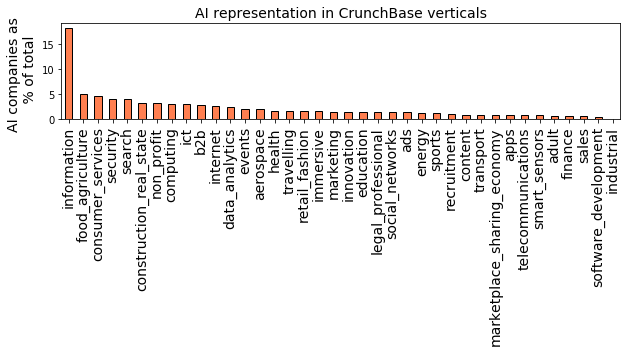

In [70]:
ax = ai_sector_df.sort_values('shares',ascending=False)['shares'].plot.bar(figsize=(9,5),color='coral',edgecolor='black')
ax.set_ylabel('AI companies as \n % of total',size=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.set_title('AI representation in CrunchBase verticals',size=14)

plt.tight_layout()

plt.savefig('/Users/jmateosgarcia/Desktop/company_focus.pdf')

How many AI companies in finance in the UK?

In [71]:
uk_finance = comps_cats.loc[(comps_cats['country']=='United Kingdom')&(['finance' in x for x in comps_cats['sector_list']])]

In [72]:
print(len(uk_finance)) 
print(uk_finance['ai_flag'].sum())

780
8


### Final tidy up

In [73]:
vars_to_drop = ['permalink','domain','email','phone','facebook_url','linkedin_url','logo_url','is_health','mesh_terms','organization',
               'parent_id','organization_id']

In [74]:
uk_comps = comps_cats.loc[(comps_cats['country']=='United Kingdom'),[x for x in comps_cats.columns if x not in vars_to_drop]]
uk_comps.to_csv(f'{today_str}_cb_uk.csv',compression='gzip')

### Create data dictionary

In [75]:
print('|name|type|observations|')
print('|----|----|----|')

for c in uk_comps.columns:
    
    print(f'|{c}|{type(uk_comps[c].iloc[0])}|   |')

|name|type|observations|
|----|----|----|
|id|<class 'str'>|   |
|company_name|<class 'str'>|   |
|roles|<class 'str'>|   |
|homepage_url|<class 'str'>|   |
|country|<class 'str'>|   |
|state_code|<class 'NoneType'>|   |
|region|<class 'str'>|   |
|city|<class 'str'>|   |
|location_id|<class 'str'>|   |
|address|<class 'str'>|   |
|status|<class 'str'>|   |
|short_description|<class 'str'>|   |
|funding_rounds|<class 'numpy.int64'>|   |
|funding_total_usd|<class 'numpy.float64'>|   |
|founded_on|<class 'pandas._libs.tslib.Timestamp'>|   |
|last_funding_on|<class 'pandas._libs.tslib.NaTType'>|   |
|closed_on|<class 'pandas._libs.tslib.NaTType'>|   |
|employee_count|<class 'str'>|   |
|cb_url|<class 'str'>|   |
|twitter_url|<class 'NoneType'>|   |
|aliases|<class 'NoneType'>|   |
|created_at|<class 'pandas._libs.tslib.Timestamp'>|   |
|updated_at|<class 'pandas._libs.tslib.Timestamp'>|   |
|primary_role|<class 'str'>|   |
|type|<class 'str'>|   |
|long_description|<class 'float'>|   |
|c